# Exercise 12: Dimensionality reduction

## Table of Contents

* Linear algebra based methods
    * PCA
    * jPCA
* Information theory based methods
    * Granger causality
    * ICA 
    * DCA
* Classifier
    * SVM

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

# For downloading data from the web
import urllib

# To load Sabes data
# from dca.data_util import load_sabes_data

# For PCA, ICA
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import Ridge as RR
from sklearn.metrics import r2_score

# For jPCA
import jPCA
from jPCA.util import load_churchland_data, plot_projections

# For Dynamical Component Analysis
# from dca.dca import DynamicalComponentsAnalysis as DCA

# For retina displays only 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

## Linear alegbra based methods 

### PCA

#### PCA on test data 

In [3]:
N = 200
s1 = 5
s2 = 2
theta = np.pi / 6

X1 = np.random.normal(loc=0, scale=s1, size=N)
X2 = np.random.normal(0, s2, N)
R = np.array(
    [[np.cos(theta), np.sin(theta)], 
     [-np.sin(theta), np.cos(theta)]])
X = np.vstack((X1, X2)).T
Y = X@R

In [4]:
Y

array([[-2.23725749e+00,  8.15558492e-01],
       [ 1.26052838e+00, -3.73950086e-01],
       [-2.63956976e-02,  1.16710098e+00],
       [ 4.78372205e+00,  3.19567895e+00],
       [ 7.73480805e-01,  4.97697201e-01],
       [-1.55638168e+00,  5.70480108e-01],
       [-3.10643712e+00, -2.13348500e+00],
       [ 1.02945192e+00, -4.46848529e-01],
       [-5.94681423e-01, -1.05371945e+00],
       [-4.43394289e+00,  3.81072522e-01],
       [ 1.61839726e-01, -1.94537055e+00],
       [ 9.48385315e-01,  8.71474879e-01],
       [ 6.14770900e+00,  4.71076787e+00],
       [-5.36305270e-01,  7.02774307e-01],
       [ 1.97463808e+00, -2.47043503e+00],
       [ 1.46959882e+00,  2.37022411e+00],
       [ 6.49250442e-01,  4.44412828e-01],
       [ 1.20999906e+00,  3.19626883e+00],
       [ 3.16978370e+00,  1.90246783e+00],
       [ 3.93364522e+00,  1.81922261e-01],
       [ 3.76218921e+00,  1.82831534e+00],
       [ 4.01241397e+00, -1.17003486e-01],
       [-7.52163833e-01, -7.77523473e-03],
       [-2.

Text(0, 0.5, 'Original data dim. 2')

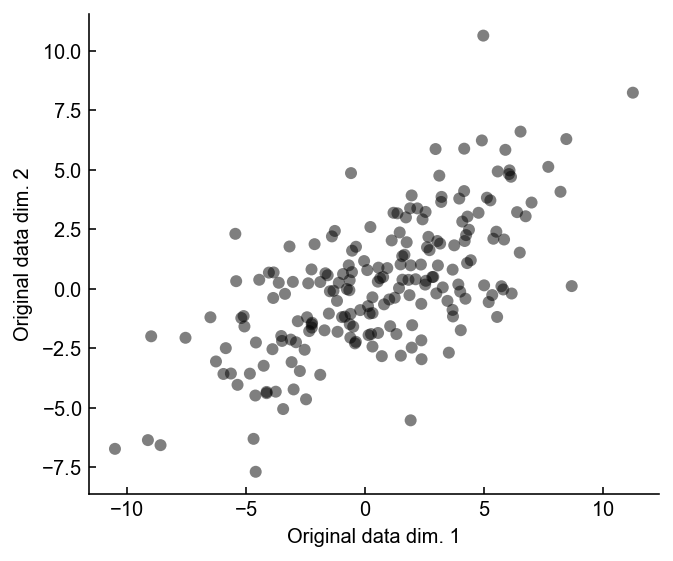

In [9]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(Y[:,0], Y[:,1], color='k', alpha=.5, edgecolors='none')
ax.set_xlabel("Original data dim. 1")
ax.set_ylabel("Original data dim. 2")

In [10]:
pca_test_model = PCA()
pca_test_model.fit(Y)

PCA()

In [11]:
proj = pca_test_model.components_
print(proj)

PCA_1 = np.array(proj[0,:])
PCA_2 = np.array(proj[1,:])

[[ 0.84046549  0.54186507]
 [-0.54186507  0.84046549]]


In [12]:
vals = pca_test_model.explained_variance_
print(f"The observed variances are {vals},\nand the corresponding standard deviations are {np.sqrt(vals)}")

The observed variances are [19.69025042  3.43152106],
and the corresponding standard deviations are [4.43736976 1.85243652]


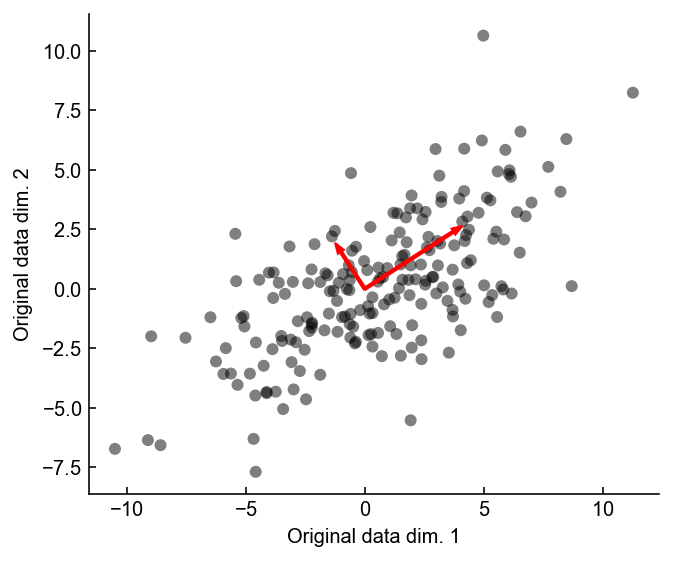

In [13]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(Y[:,0], Y[:,1], alpha=.5, color='k', edgecolor='none')
ax.set_xlabel("Original data dim. 1")
ax.set_ylabel("Original data dim. 2")
ax.arrow(0, 0, *(np.sqrt(vals[0])*PCA_1), width=.1, color='r')
ax.arrow(0, 0, *(np.sqrt(vals[1])*PCA_2), width=.1, color='r')

Text(0, 0.5, 'PC 2')

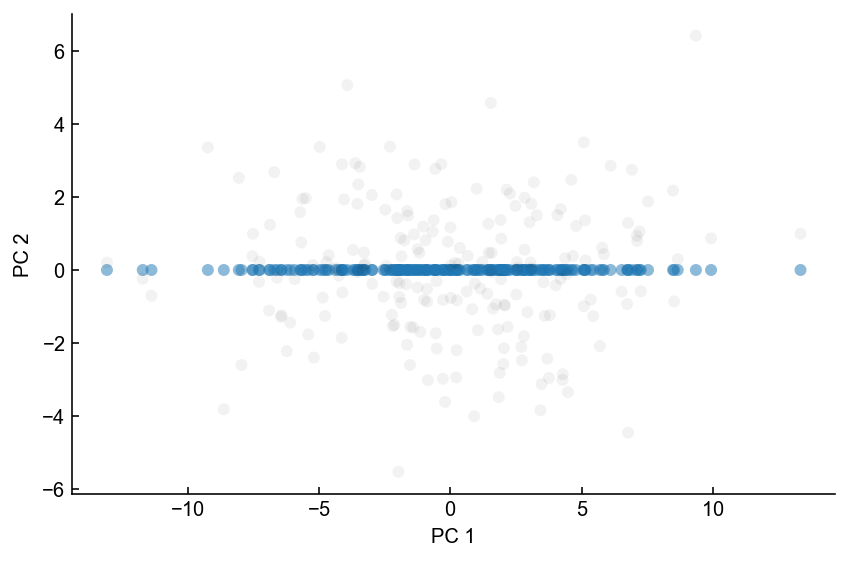

In [14]:
Y_pca = pca_test_model.transform(Y)
fig, ax = plt.subplots()
ax.scatter(Y_pca[:,0], np.zeros_like(Y_pca[:,0]), alpha=.5, edgecolor='none')
ax.scatter(Y_pca[:,0], Y_pca[:,1], alpha=.05, color='k', edgecolor='none')
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

#### PCA on neural data 

Due to some combination of simple experimental paradigms and more fundamental unknown principles of cortical processing, the neural data we recorded is often much lower dimensional than the recording dimensionality. This tutorial explores a few different ways of thinking about neural dimensionality. It contrasts DCA with the commonly used PCA.

**Run once to download the M1 reaching data** 

The file is 1.1 GB, so it may take a few minutes to download. This data is from the Sabes lab and is recordings from M1 while a monkey is reaching to different locations on a grid. This is the same data used in the DCA paper. In this tutorial, we won't cross validate the results as was done in the paper to keep things simple.

More information and data can be found here:

O'Doherty, Joseph E., Cardoso, Mariana M. B., Makin, Joseph G., & Sabes, Philip N. (2017). Nonhuman Primate Reaching with Multichannel Sensorimotor Cortex Electrophysiology [Data set]. Zenodo. http://doi.org/10.5281/zenodo.583331

In [15]:
sabes_path = os.path.join('.', 'data', 'sabes-example-data.mat')

In [16]:
# Run once to download data
if not os.path.isfile(sabes_path): # check if file was already downloaded
    urllib.request.urlretrieve('https://zenodo.org/record/583331/files/indy_20160627_01.mat?download=1', sabes_path)

In [17]:
sabes_data = load_sabes_data(sabes_path, bin_width_s=.05, preprocess=True)

In [18]:
keys = sabes_data.keys()
print(sabes_data.keys())
print(*[(key, sabes_data[key].shape) for key in keys])

dict_keys(['M1', 'cursor'])
('M1', (67258, 109)) ('cursor', (67258, 2))


In [21]:
# M1 data
sabes_X = sabes_data['M1']
sabes_Xn = sabes_X / sabes_X.std(axis=0, keepdims=True) # normalized version will be used later

# Motor output 
sabes_Y = sabes_data['cursor']

Text(0, 0.5, 'cursor y')

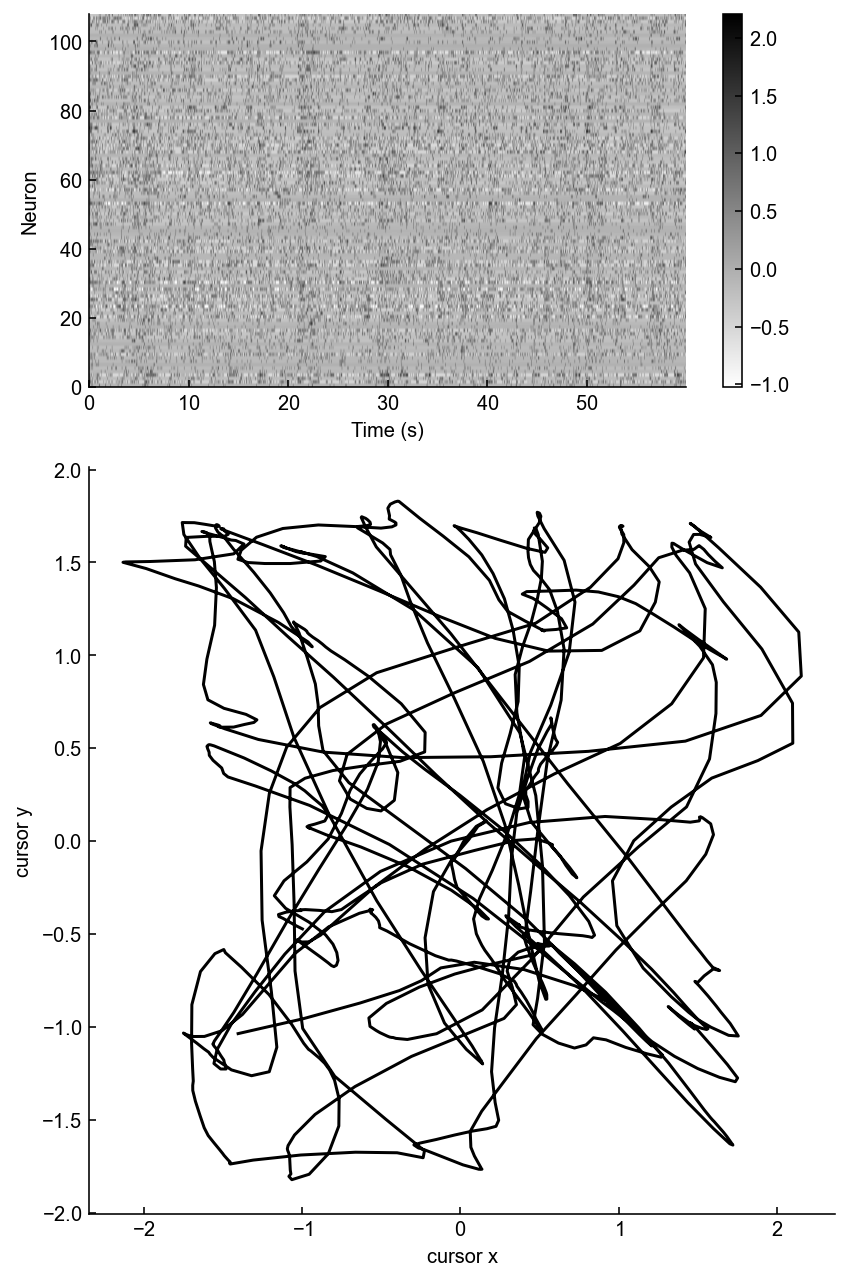

In [22]:
# Plotting the data and motor outplut
fig, (ax_neural, ax_cursor) = plt.subplots(nrows=2, figsize=(6,9), gridspec_kw={'height_ratios': [1,2]})

data_map = ax_neural.imshow(sabes_X[:1200].T, extent=[0, 1199*.05, 0, 108], cmap='gray_r', aspect='auto')
ax_neural.set_xlabel('Time (s)')
ax_neural.set_ylabel('Neuron')
fig.colorbar(data_map, ax=ax_neural)

ax_cursor.plot(*sabes_Y[:1200].T, c='k')
ax_cursor.set_xlabel('cursor x')
ax_cursor.set_ylabel('cursor y')

In [23]:
# Running the PCA model for the data 
pca_model = PCA()
pca_model.fit(sabes_X)

PCA()

The top 6 are above the noise floor.


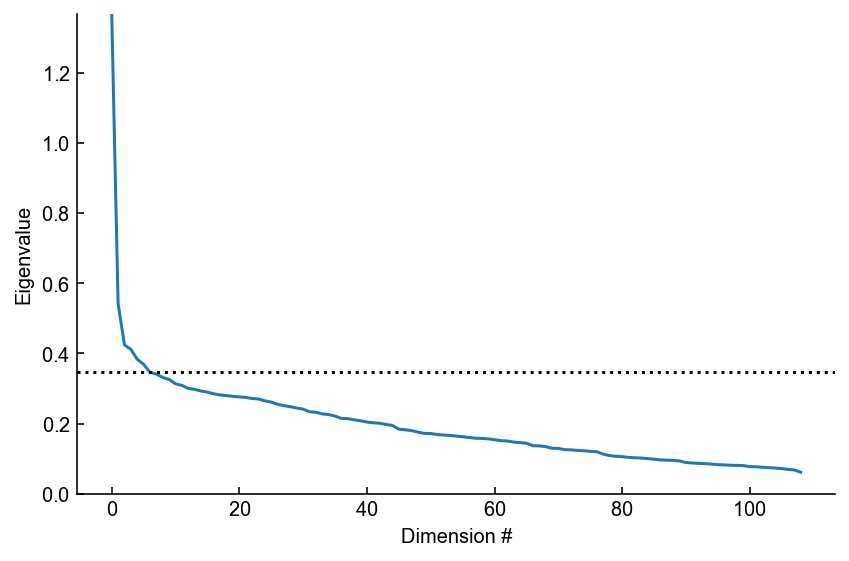

In [24]:
# Plotting the eigenvalues
eig_vals = pca_model.explained_variance_
noise = .15 # would be estimated from multiple trials...
noise_cutoff = 4*noise/np.sqrt(3)

fig, ax = plt.subplots()
ax.plot(eig_vals)
ax.axhline(noise_cutoff, color='k', linestyle='dotted')
ax.set_ylim(0, eig_vals[0])
ax.set_ylabel("Eigenvalue")
ax.set_xlabel("Dimension #")

num_eigs_to_keep = np.nonzero(eig_vals > noise_cutoff)[0][-1] + 1
print(f"The top {num_eigs_to_keep} are above the noise floor.")

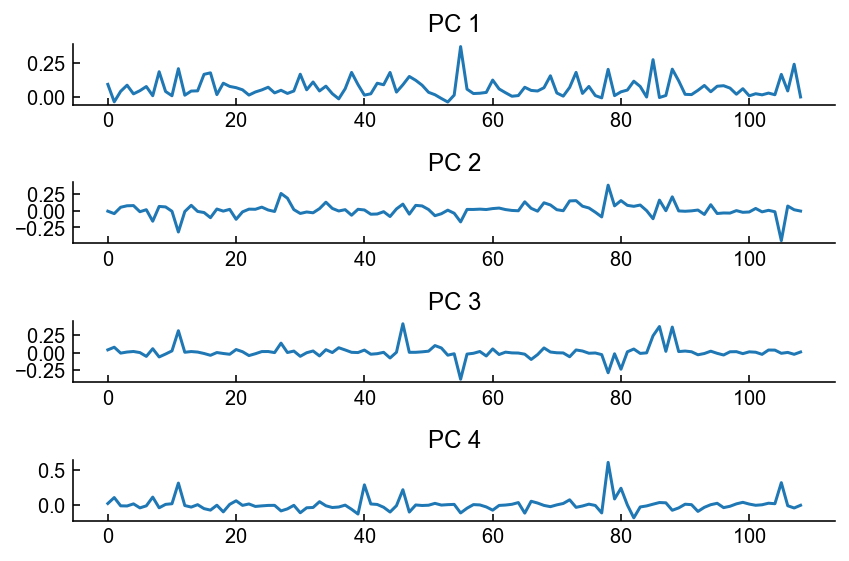

In [25]:
# Plotting the first 4 PCs
fig, axs = plt.subplots(nrows=4)
for i in range(4):
    axs[i].plot(pca_model.components_[i])
    axs[i].set_title(f"PC {i+1}")

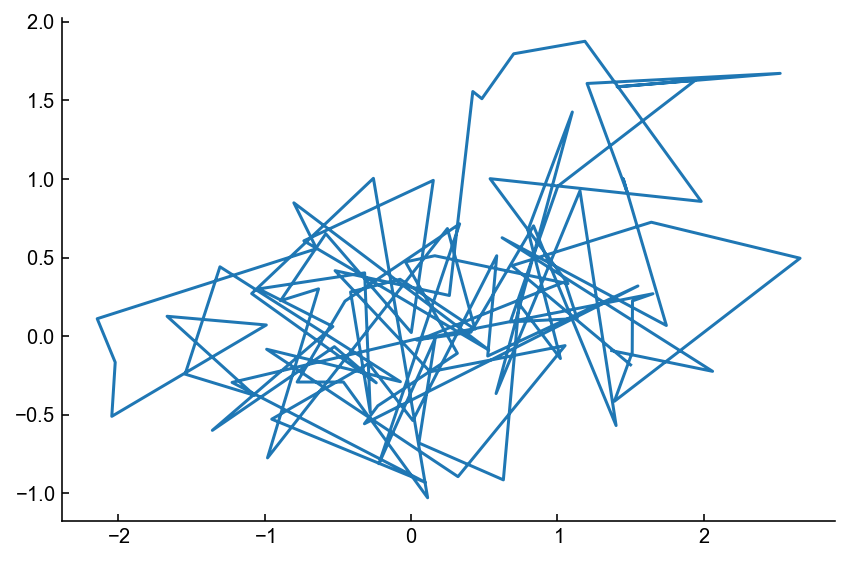

In [27]:
# Plotting the activity in the first 2 PCAs
fig, ax = plt.subplots()
sabes_X_pca = pca_model.transform(sabes_X)

PCA_1 = sabes_X_pca[:,0]
PCA_2 = sabes_X_pca[:,1]

ax.plot(PCA_1[:100], PCA_2[:100])

In [ ]:
# How much of the behavior do these components explain? 
max_dim = 30
lag = 4 # 200ms lag for the neural data for predicting behavior

In [ ]:
ds = np.arange(1, max_dim+1)
var = np.sum(pca_model.explained_variance_)

pca1_scores = np.zeros(ds.size)
for ii, d in enumerate(ds):
    Xd = pca_model.transform(sabes_X)[:, :d]
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd[:-lag], sabes_Y[lag:])
    pca1_scores[ii] = r2_score(sabes_Y[lag:], rr_model.predict(Xd[:-lag]))
rr_model = RR(alpha=1e-6)
rr_model.fit(sabes_X[:-lag], sabes_Y[lag:])
max_score = r2_score(sabes_Y[lag:], rr_model.predict(sabes_X[:-lag]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(ds, np.cumsum(pca_model.explained_variance_)[:ds.size] / var, label='Var. explained')
ax.plot(ds, pca1_scores / max_score, label=r'$R^2$')
ax.set_ylim(0, 1)
ax.legend(loc='best')
ax.set_xlabel('Projected dimensionality')
ax.set_ylabel('0-1 normalized metric')

### jPCA

**Run once to download the Churchland data**

Data and method from Churchland MM et al. (2012)  Structure of neural population dynamics during reaching. Nature. 

In [28]:
churchland_path = os.path.join('.', 'data', 'churchland-example-data.mat')

In [29]:
if not os.path.isfile(churchland_path): # check if file was already downloaded
    urllib.request.urlretrieve('https://www.dropbox.com/sh/2q3m5fqfscwf95j/AAC7fpAr5Sc3FN--nnZMX3sla/exampleData.mat?dl=1', churchland_path)

In [30]:
churchland_data, times = load_churchland_data(churchland_path)

In [31]:
# Create a jPCA object
jpca_model = jPCA.JPCA(num_jpcs=2)
projected, full_data_var, pca_var_capt, jpca_var_capt = jpca_model.fit(churchland_data, times=times, tstart=-50, tend=150)

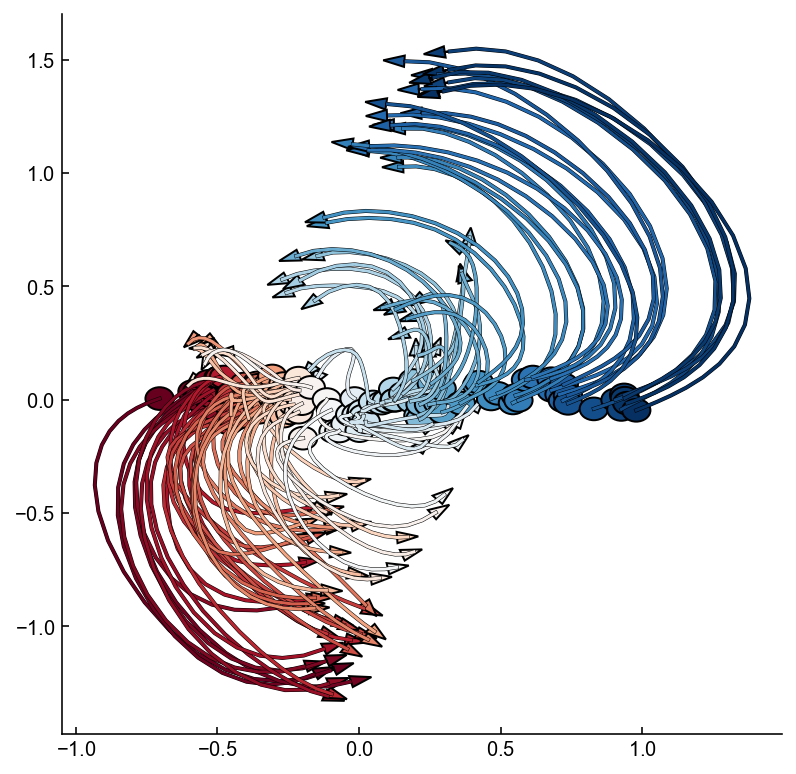

In [32]:
# Plot the projected data
plot_projections(projected)

## Information theory based methods

### ICA 

#### ICA on test data 

In [33]:
N = 200
s1 = 5
s2 = 2
theta = np.pi / 6

X1 = np.random.normal(loc=0, scale=s1, size=N)
X2 = np.random.normal(0, s2, N)
R = np.array(
    [[np.cos(theta), np.sin(theta)], 
     [-np.sin(theta), np.cos(theta)]])
X = np.vstack((X1, X2)).T
Y = X@R

Text(0, 0.5, 'Original data dim. 2')

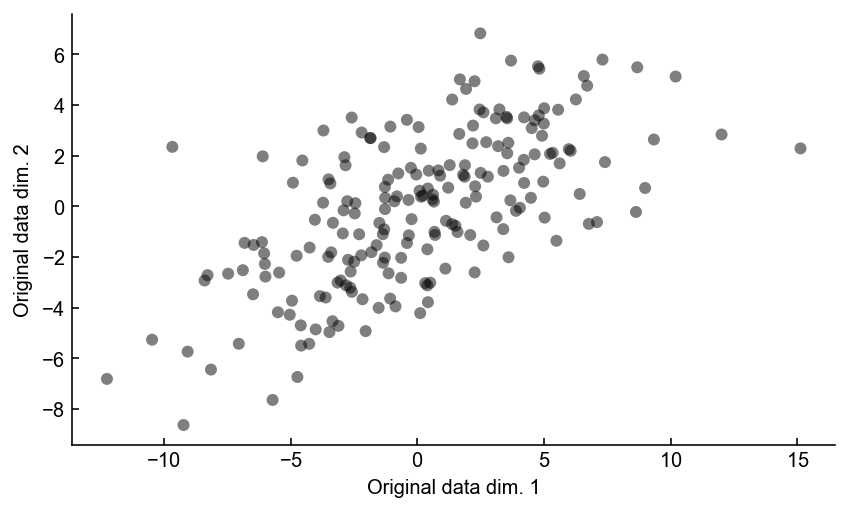

In [34]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(Y[:,0], Y[:,1], color='k', alpha=.5, edgecolors='none')
ax.set_xlabel("Original data dim. 1")
ax.set_ylabel("Original data dim. 2")

In [35]:
ica_test_model = FastICA()
ica_test_model.fit(Y)

FastICA()

In [36]:
proj = ica_test_model.components_
print(proj)

ICA_1 = np.array(proj[0,:])
ICA_1 /= np.sqrt((ICA_1**2).sum())
ICA_2 = np.array(proj[1,:])
ICA_2 /= np.sqrt((ICA_2**2).sum())

[[ 0.02059022 -0.01625996]
 [-0.00286286  0.02621965]]


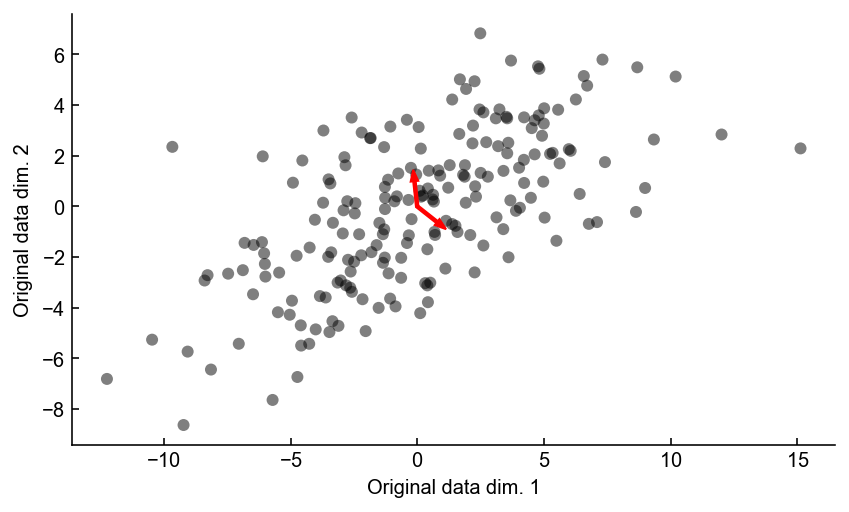

In [37]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(Y[:,0], Y[:,1], alpha=.5, color='k', edgecolor='none')
ax.set_xlabel("Original data dim. 1")
ax.set_ylabel("Original data dim. 2")
ax.arrow(0, 0, *ICA_1, width=.1, color='r')
ax.arrow(0, 0, *ICA_2, width=.1, color='r')

Text(0, 0.5, 'IC 2')

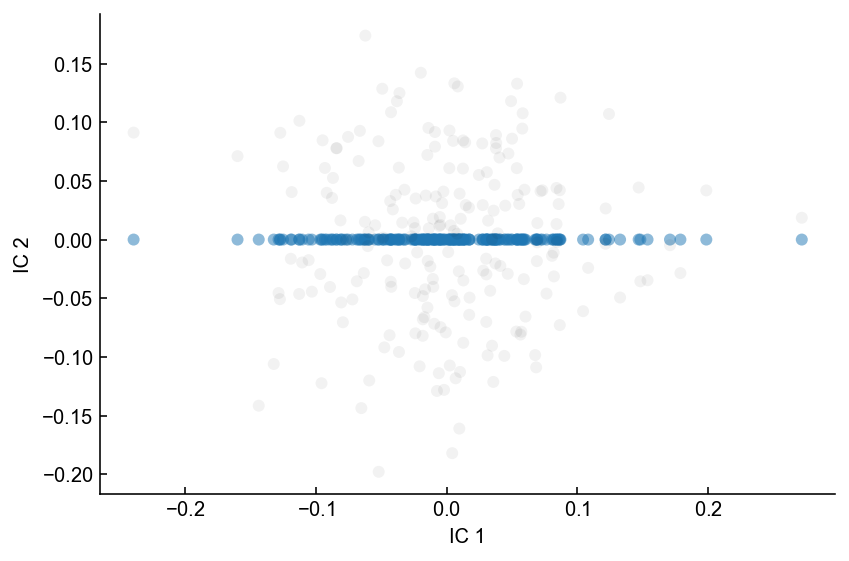

In [38]:
Y_ica = ica_test_model.transform(Y)
fig, ax = plt.subplots()
ax.scatter(Y_ica[:,0], np.zeros_like(Y_ica[:,0]), alpha=.5, edgecolor='none')
ax.scatter(Y_ica[:,0], Y_ica[:,1], alpha=.05, color='k', edgecolor='none')
ax.set_xlabel("IC 1")
ax.set_ylabel("IC 2")

#### Running ICA on neural data

In [39]:
# Running the PCA model for the data 
ica_model = FastICA()
ica_model.fit(sabes_X)

FastICA()

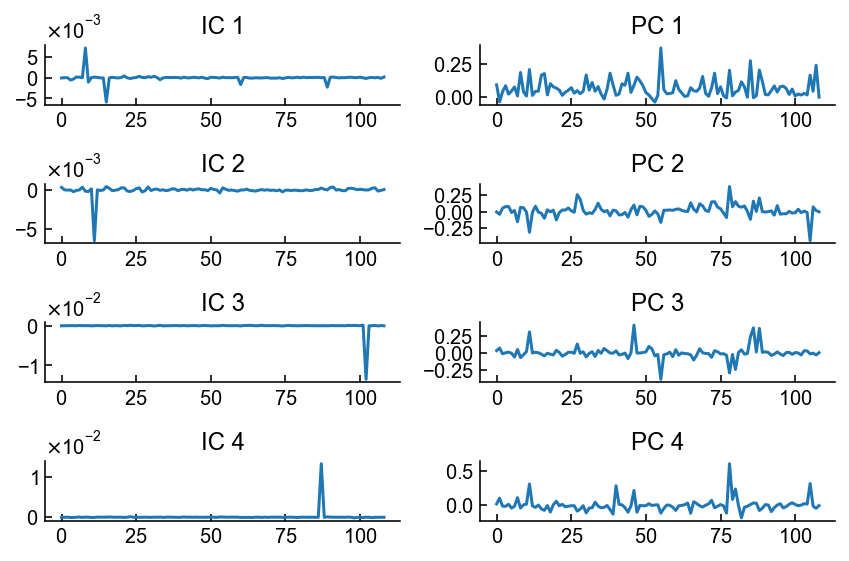

In [40]:
# Plotting the first 4 ICs
fig, axs = plt.subplots(nrows=4, ncols=2)
for i in range(4):
    axs[i, 0].plot(ica_model.components_[i])
    axs[i, 0].set_title(f"IC {i+1}")
    axs[i, 1].plot(pca_model.components_[i])
    axs[i, 1].set_title(f"PC {i+1}")


### Granger causality 

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
T_f = 10
f = 0.5

T = np.linspace(0, T_f, 1000)
X1 = np.sin(2*np.pi*f*T) + np.random.normal(0, .2, len(T))
X2 = np.sin(2*np.pi*f*(T-.3)) + np.random.normal(0, .2, len(T))

Xs = np.vstack((X1, X2)).T

In [ ]:
fig, ax = plt.subplots()
ax.plot(T, X1, color='.8', label='X1')
ax.plot(T, X2, color='.6', label='X2')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (au)')

ax.legend()

In [ ]:
grangercausalitytests(Xs, maxlag=50)

### DCA

In [ ]:
dca_model = DCA(T=10, d=109)
dca_model.estimate_data_statistics(X) # only need to estimate this once
dca_model.fit(X)

In [ ]:
# Plotting the activity in the first 2 PCAs
fig, ax = plt.subplots()
X_dca_t = dca_model.transform(X)

DCA_1 = X_dca_t[:,0]
DCA_2 = X_dca_t[:,1]

ax.plot(DCA_1[:10], DCA_2[:10])

In [ ]:
# Examining PI 
pi = np.zeros(ds.size)
dca_scores = np.zeros(ds.size)
max_pi = dca_model.score() # PI of data with no dimensionality reduction

In [ ]:
for ii, d in enumerate(ds):
    dca_model.fit_projection(d=d)
    pi[ii] = dca_model.score()
    Xd = dca_model.transform(X)
    rr_model = RR(alpha=1e-6)
    rr_model.fit(Xd[:-lag], Y[lag:])
    dca_scores[ii] = r2_score(Y[lag:], rr_model.predict(Xd[:-lag]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(ds, pi / max_pi, label='PI')
ax.plot(ds, dca_scores / max_score, label=r'$R^2')
ax.ylim(0, 1)
ax.legend(loc='best')
ax.set_xlabel('Projected dimensionality')
ax.set_ylabel('0-1 normalized metric')